# **Task \#2**: Machine Learning MC886/MO444
##**Classical Machine Learning Techniques**##

In [1]:
print('Daniel Gardin Gratti ' + '214729')
print('Name2' + ' RA2')

Daniel Gardin Gratti214729
Name2 RA2


## Objective:

To explore **Linear Regression** and **Logistic Regression** alternatives and come up with the best possible model for the problems, at the same time avoiding overfitting (and also underfitting). In this work, we will train a model that use medical records from patients to predict patient survival.

## Dataset

The purpose of this dataset is to predict the patients' survival from medical records. These data is available in [Google Sheets](https://docs.google.com/spreadsheets/d/18-PlYBnwD7yJoyGJOsaB5Wydc2iTG9sSnbuuV4t4efE/edit?usp=sharing), consisting in 299 patients with heart failure collected in 2015. 

**Data Dictionary**:

- **AGE**: Age of the patient (years);

- **ANAEMIA**: Decrease of red blood cells or hemoglobin (boolean);

- **HIGH BLODD PRESSURE**: If the patient has hypertension (boolean);

- **CREATININE PHOSPHOKINASE (CPK)**: Level of the CPK enzyme in the blood (mcg/L);

- **DIABETES**: If the patient has diabetes (boolean);

- **EJECTION FRACTION**: Percentage of blood leaving the heart at each contraction (percentage);

- **PLATELETS**: Platelets in the blood (kiloplatelets/mL);

- **SEX**: Woman or man (binary);

- **SERUM CREATININE**: Level of serum creatinine in the blood (mg/dL);

- **SERUM SODIUM**: Level of serum sodium in the blood (mEq/L);

- **SMOKING**: If the patient smokes or not (boolean);

- **TIME**: Follow-up period (days);

- **DEATH EVENT**: If the patient deceased during the follow-up period (boolean);

More information about the dataset: *Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5*

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

df = pd.read_csv('heart_dataset.csv').drop(columns=['time'])
df = df.dropna()

df["female"]   =(df["sex"] == "Female").astype(int)
df = df.drop(columns=['sex'])
df["anaemia"]  = (df["anaemia"] == "Yes").astype(int)
df["diabetes"] = (df["diabetes"] == "Yes").astype(int)
df["smoking"] = (df["smoking"] == "Yes").astype(int)
df["high_blood_pressure"] = df["high_blood_pressure"].apply(int)

df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,DEATH_EVENT,female
0,75.0,0,582.0,0,20.0,1,265000.00,1.9,130.0,0,1,1
1,55.0,0,7861.0,0,38.0,0,263358.03,1.1,136.0,0,1,1
2,65.0,0,146.0,0,20.0,0,162000.00,1.3,129.0,1,1,1
3,50.0,1,111.0,0,20.0,0,210000.00,1.9,137.0,0,1,1
5,90.0,1,47.0,0,40.0,1,204000.00,2.1,132.0,1,1,1


### Analysis


(0.5 points) This part of the assignmente aims to analyze the dataset and preprocess the data for the models. To do so, a fews things to be considered: 


*   Are there any outliers?
*   Are there missing values?
*   How will you handle categorical variables?

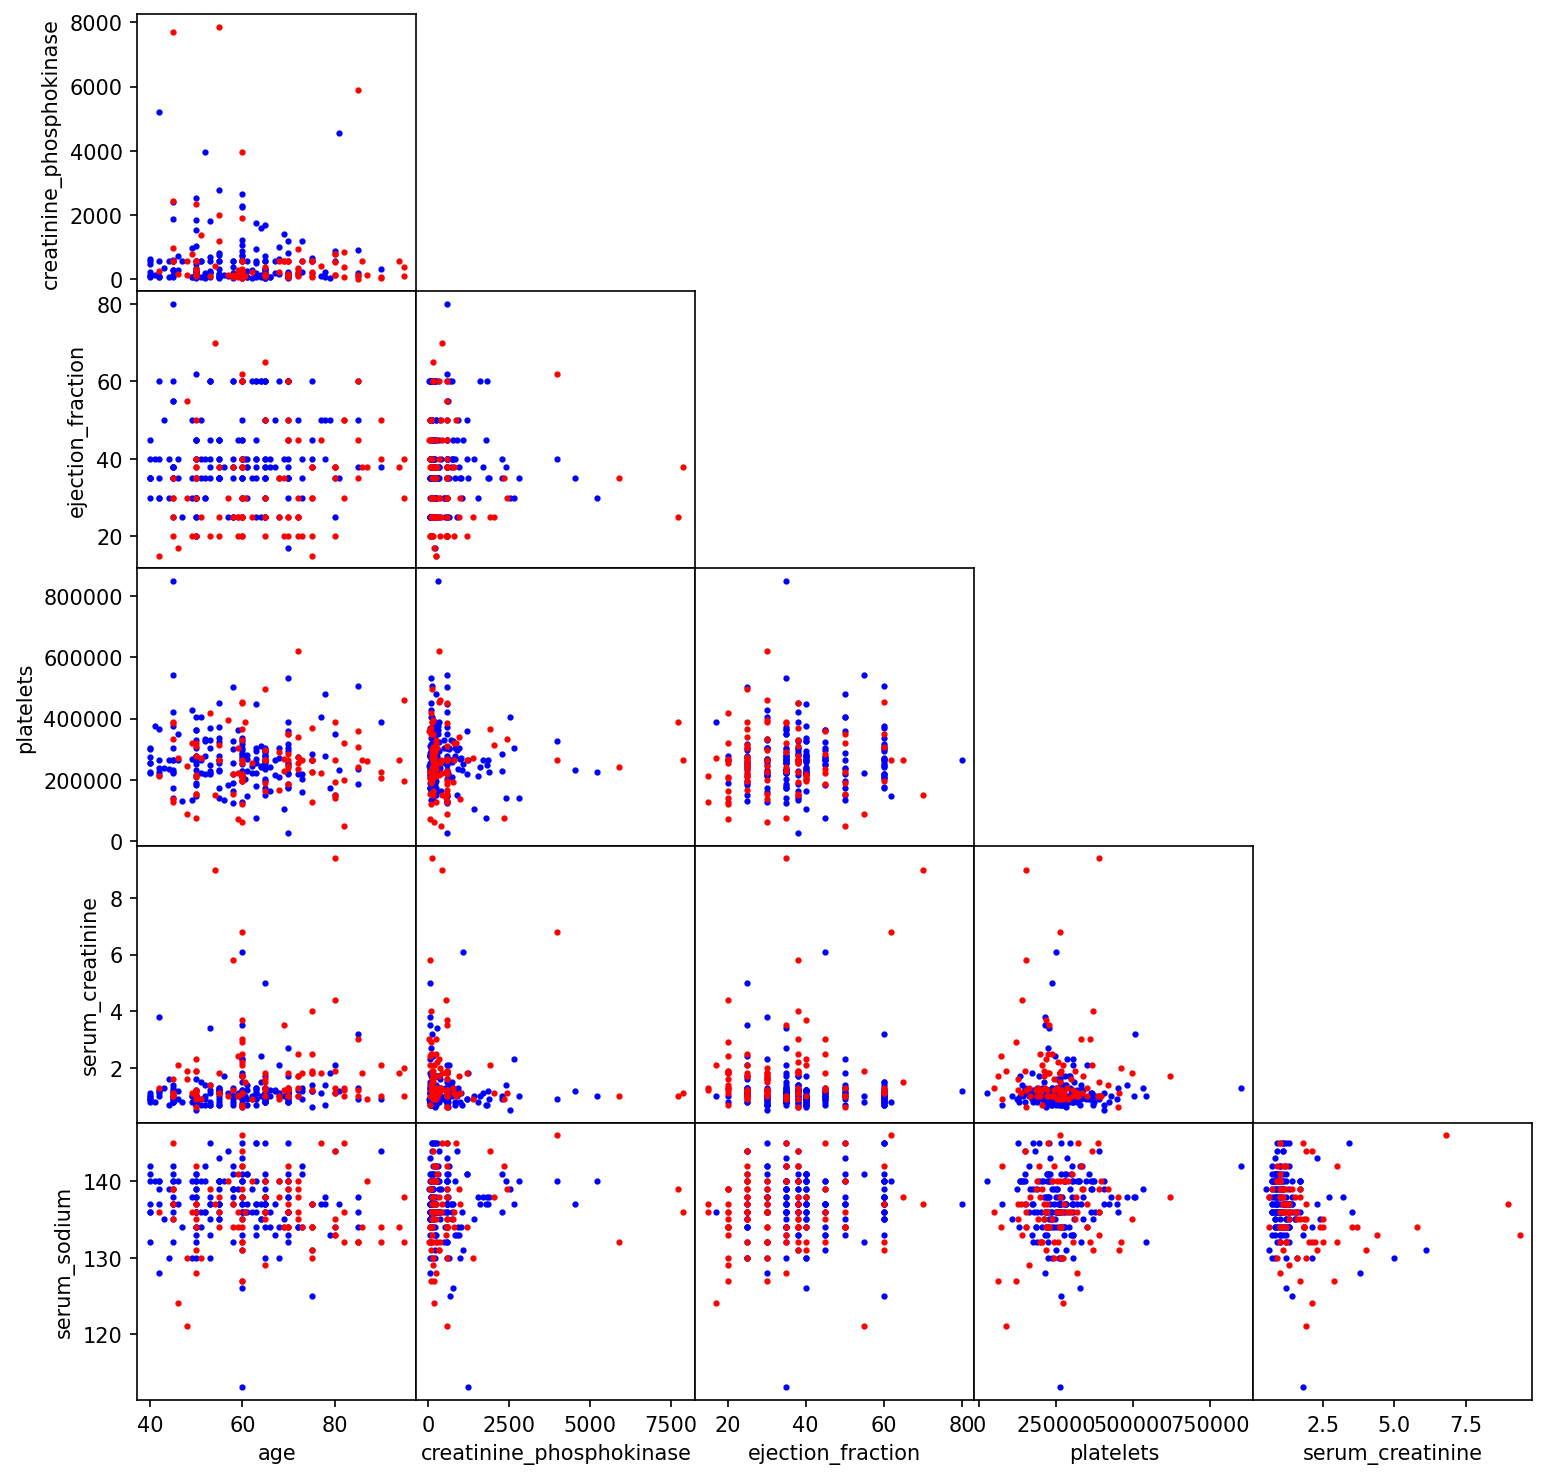

In [61]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12), dpi=150)

NUM_LABELS = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

for i in range(5):
    axs[i, 0].set_ylabel(NUM_LABELS[i + 1])
    axs[4, i].set_xlabel(NUM_LABELS[i])

for i in range(5):
    for j in range(5):
        if i != 4: axs[i, j].set_xticks([])
        if j != 0: axs[i, j].set_yticks([])
        if i < j:  
            axs[i, j].set_axis_off()
            continue

        positive_y = df[NUM_LABELS[i+1]][df["DEATH_EVENT"] == 1]
        negative_y = df[NUM_LABELS[i+1]][df["DEATH_EVENT"] == 0]
        positive_x = df[NUM_LABELS[j]][df["DEATH_EVENT"] == 1]
        negative_x = df[NUM_LABELS[j]][df["DEATH_EVENT"] == 0]

        axs[i, j].scatter(negative_x, negative_y, s=4, color='blue')
        axs[i, j].scatter(positive_x, positive_y, s=4, color='red')

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('correlation.png')

plt.show()

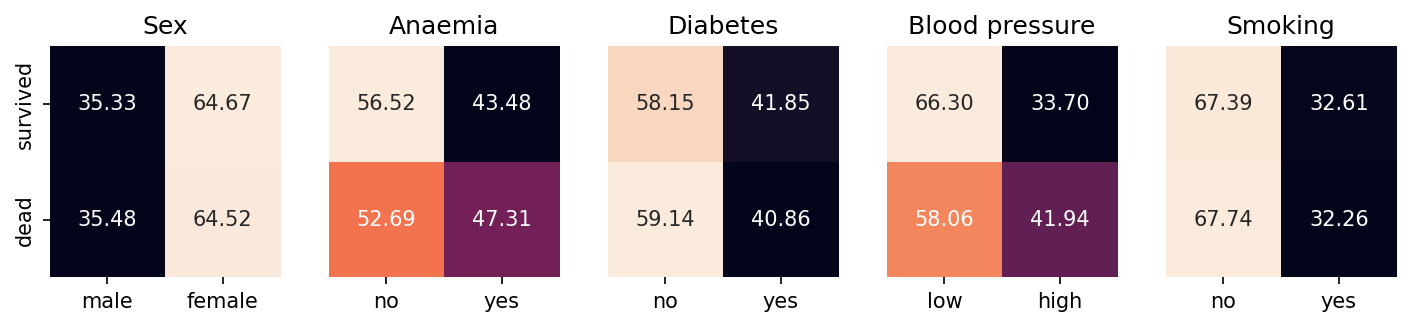

In [137]:
fig, axs = plt.subplots(ncols=5, figsize=(12, 2), dpi=150)

DEATH = df['DEATH_EVENT'].to_numpy()
CATEG_LABELS = ['female', 'anaemia', 'diabetes', 'high_blood_pressure', 'smoking']
TITLES = ['Sex', 'Anaemia', 'Diabetes', "Blood pressure", "Smoking"]
LABELS = [
    ['male', 'female'],
    ['no', 'yes'],
    ['no', 'yes'],
    ['low', 'high'],
    ['no', 'yes']
]

for i in range(5):
    categ = df[CATEG_LABELS[i]].to_numpy()

    matrix = np.zeros((2,2))

    for idx in range(len(DEATH)):
        matrix[DEATH[idx], categ[idx]] += 1
    
    matrix = 100* matrix / matrix.sum(axis=1)[:, None]

    sns.heatmap(matrix, annot=True, fmt='.2f', ax=axs[i], cbar=False, square=True)

    axs[i].set_title(TITLES[i])
    axs[i].set_xticklabels(LABELS[i])
    if i == 0: axs[i].set_yticklabels(['survived', 'dead'])
    else:      axs[i].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()


## Linear Regression

(0.75 points) This part of the assigment aims to predict the level of serum creatinine in the blod based on their medical records. 

*   Do we need to split the data into train, valid and test? How?
*   Do we need to normalize the data? How? The normalization is equal to train, valid and test split?
* **Target value: serum_creatinine**.

Obs: drop the DEATH_EVENT column.

In [ ]:
# TODO: Split data and normalize. You can use scikit-learn libraries.

### Activities

1. (0.5 points) Verify if there is any feature that has low correlation with the target variables. You can use the function [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) to check the importance of each feature. 

> *   Do we need all the features to predict the target value?
> *   What happens if we drop the low correlation features?

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# TODO: Feature selection.

> What are the conclusions? (1-2 paragraphs)

2. (2.0 points) Perform Linear Regression. You should implement your solution and compare it with ```sklearn.linear_model.SGDRegressor``` (linear model fitted by minimizing a regularized empirical loss with SGD, http://scikit-learn.org).

In [ ]:
# TODO: MSE Loss. You cannot use scikit-learn!!
def MSE():
  return None

In [ ]:
# TODO: Linear Regression. Implement yout solution. You cannot use scikit-learn, Keras/TensorFlow, or PyTorch libraries!!
class LinearRegression():
  def __init__(self, learning_rate=-1, max_iter=-1):
    self.max_iter         = max_iter
    self.learning_rate    = learning_rate
    self.weights          = None
    self.bias             = None

  def predict(self, X):
    return None

  def fit(self, X, y):
    return None

In [ ]:
# TODO: Linear Regression. You can use scikit-learn libraries.
from sklearn.linear_model import SGDRegressor

> What are the conclusions? (1-2 paragraphs)

3. (0.5 points) Plot the cost function vs. number of epochs in the training/validation set and analyze the model. 

In [ ]:
# TODO: Plot the cost function vs. number of iterations in the training set.

> What are the conclusions? (1-2 paragraphs)

4. (0.75 points) Use different learning rates when optimizing the model. You can use the model that you implemented or the model from scikit-learn.

> If you prefer to use the SGDRegressor from scikit-learn, use the parameter ```learning_rate='constant'``` and change the ```eta0```.

In [ ]:
# TODO: Different learning rates. You can use scikit-learn libraries.

> What are the conclusions? (1-2 paragraphs)

5. (0.5 points) Sometimes, we need some more complex function to make good prediction. Evaluate a [Polynomial Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) model. 

In [ ]:
# TODO: Complex model. You can use scikit-learn libraries.

> What are the conclusions? (1-2 paragraphs)

6. (0.5 points) Pick **your best model**, based on your validation set, and predict the target values for the test set.

In [ ]:
# TODO: Plot the true label and the predict label

## Logistic Regression

This part of the assigment aims to predict the patients survival based on their medical records. 

*   Do we need to split the data into train, valid and test? How?
*   Do we need to normalize the data? How? The normalization is equal to train, valid and test split?
* **Target value: DEATH EVENT**.

1. (0.5 points) Verify if there is any feature that has low correlation with the target variables. You can use the function [mutual_info_classification](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) to check the importance of each feature.

In [141]:
from sklearn.feature_selection import mutual_info_classif

mutual_info_classif(df.loc[:, df.columns != "DEATH_EVENT"].to_numpy(), df["DEATH_EVENT"].to_numpy())

array([0.08159464, 0.02243512, 0.02039953, 0.00552087, 0.07285534,
       0.00044971, 0.        , 0.11313554, 0.0533807 , 0.        ,
       0.02861112])

> What are the conclusions? (1-2 paragraphs)

2. (2 points) Perform Multinomial Logistic Regression.

In [ ]:
# TODO: Logistic Regression. You can use scikit-learn libraries.

> What are the conclusions? (1-2 paragraphs)


3. (1.5 points) Another factor that can alter the model result it's if the dataset is balanced:

*   The dataset is balanced ?
*   In this case, which technique is better: *oversampling* or *undersampling*?

Obs: You can use [RandomOverSampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) and [RandomUnderSampling](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler). But you can try others techniques.

In [ ]:
# TODO: Oversampling. You can use scikit-learn and imblearn libraries.

In [ ]:
# TODO: Undersampling. You can use scikit-learn and imblearn libraries.

> What are the conclusions? (1-2 paragraphs)

4. (0.5 points) Pick **your best model** and plot the confusion matrix in the **test set**. 


In [ ]:
# TODO: Plot the confusion matrix. You can use scikit-learn, seaborn, matplotlib libraries.

> What are the conclusions? (1-2 paragraphs)

## Deadline

Wednesday, April 19, 11:59 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- April 20, 11:59 pm : grade * 0.75
- April 21, 11:59 pm : grade * 0.5
- April 22, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**